<a href="https://colab.research.google.com/github/austinli356/OTCDR/blob/main/OTCDRipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
import os, sys

shutil.rmtree('/content/OTGK_DP', ignore_errors=True)

!git clone https://github.com/Maburidi/OTGK_DP.git

sys.path.insert(0,'/content/OTGK_DP/')

Cloning into 'OTGK_DP'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 198 (delta 8), reused 1 (delta 0), pack-reused 182 (from 1)
Receiving objects: 100% (198/198), 51.22 KiB | 1.90 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
!bash OTGK_DP/install_dependencies.sh

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import os, sys
import ot

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.multi_pred import DrugRes
from sklearn.svm import SVC
from sklearn.svm import SVR
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
from tqdm import tqdm

from models import KNNClassifier
from models import KernelRegressionNN

from Gbuilder import *
from OTtools import *
from utils import *


#----------- Model Inputs ------------------------
set_name ='GDSC2'       # Choose dataset
sets = 'DrugRes'                     # The prediction task, (ADME, Tox)
task = 'classification'               # The type of the task to be done, (classification vs regression)
#---------------- Specify the measure/embdgs + and the distance metrix used in the cost matrix ---------
embdgs = False                    # If you apply an embedding scheme at the extracted features or not
otsolver = 'wasserstein'         # The used optimal transport method, GWasserstein, wasserstein, FGW
fm = 'euclidean'                  # The distance metrix to be applied in order to generate the cost matrix needed for optimal transport
gamma = 3                        # The scaling parameter used in the kernel

norm = False                      # Normalize the features on the nodes
save_sim = False
run_MLP = True
#-------------------------------------------------------------------------------
# if sets == 'ADME':
#    data = ADME(name = set_name)
# else:
#    data = Tox(name = set_name)
data = DrugRes(name = set_name)

dall = data.get_data()
dall.drop_duplicates(subset=['Cell Line_ID', 'Drug_ID'], keep='first', inplace=True)
dall.reset_index(drop=True, inplace=True)

drugset = dall.drop_duplicates(subset='Drug_ID', keep='first', inplace=False)
drugset.reset_index(drop=True, inplace=True)
# dall_shuffled = gdall.sample(frac=1, random_state=42).reset_index(drop=True)


# split_index = int(0.8 * len(dall_shuffled))


# Train = dall_shuffled.iloc[:split_index]
# Test = dall_shuffled.iloc[split_index:]

Downloading...
100%|██████████| 117M/117M [00:04<00:00, 23.9MiB/s]
Loading...
Done!


In [ ]:
#------------------- extract graph features ---------------------
compound_iso_smiles = list(drugset['Drug'])
smile_graph = {}                      # Dictinary of features
structure_graph = {}
for smile in compound_iso_smiles:
    g, feat_, _, _  = smile_to_graph2(smile, normalize= norm)
    smile_graph[smile] = feat_
    if otsolver != 'Wasserstein':
        #g, feat_, _, _  = smile_to_graph2(smile, normalize= norm)
        if len(g)>0:
          C = structure_matrix(g, method='adjency')     # harmonic_distance, adjency, shortest_path
          structure_graph[smile] = C
        else:
          drugset = drugset[drugset.Drug != smile]
          dall = dall[dall.Drug!=smile]
          drugset.reset_index(drop=True, inplace=True)
          dall.reset_index(drop=True, inplace=True)
# y_train = list(Train['Y'])
# y_test = list(Test['Y'])
# print('===========================================')
# print(f'Number of data points = {len(y_train) + len(y_test)}')
# if task == 'classification':
#     print(f'Percent of positive data points = {np.sum(y_train) / len(y_train) * 100:.2f}%')

In [ ]:
#Construct drug similarity matrice
unique_drug1 = np.asarray(list(drugset['Drug']))
unique_drug2 = unique_drug1
print('------------ Compute Similarity matrix required for training')

M = compute_distances_btw_graphs_with_embdgs(unique_drug1,unique_drug2,smile_graph = smile_graph,structure_graph = structure_graph , embdgs = embdgs, fm = fm, otsolver=otsolver) #distance matrix from optimal transport
#normalize and convert to similarity
d0 = np.mean(M[M>0])
d_similarity = np.exp(- (M**2) / (2 * d0**2))

------------ Compute Similarity matrix required for training
Processed 0 graphs out of 136
Processed 20 graphs out of 136
Processed 40 graphs out of 136
Processed 60 graphs out of 136
Processed 80 graphs out of 136
Processed 100 graphs out of 136
Processed 120 graphs out of 136


In [ ]:
def window(cell_line, window_size, step_size):
    cell_line = np.asarray(cell_line)
    windows = sliding_window_view(cell_line, window_size)[::step_size] #fragment cellline array into windows
    return windows

def cost_matrix(cell_line1, cell_line2, window_size, step_size):
    window1 = window(cell_line1, window_size, step_size)
    window2 = window(cell_line2, window_size, step_size)
    # cdist to compute the pairwise Euclidean distances.
    cost = cdist(window1, window2, metric='euclidean')
    n1, n2 = window1.shape[0], window2.shape[0]
    return n1, n2, cost

def transport_cost(cell_line1, cell_line2):
    n1, n2, cost = cost_matrix(cell_line1, cell_line2, window_size=5, step_size=1)
    a = np.ones(n1) / n1
    b = np.ones(n2) / n2
    cost_val = ot.emd2(a, b, cost)
    return cost_val

In [ ]:
#Reduce cell line expression dimensionality
cellset = dall.drop_duplicates(subset='Cell Line_ID', keep='first', inplace=False)
cellset.reset_index(drop=True, inplace=True)
c = np.asarray(list(cellset['Cell Line']))

c_stacked = np.stack(c, axis=0) #combine cell lines into matrix
# scaler = StandardScaler()
# c_stacked = scaler.fit_transform(c_stacked)
print("Stacked shape:", c_stacked.shape)

# def softmax(x):
#     ex = np.exp(x - np.max(x))
#     return ex / ex.sum()
# c_stacked = np.apply_along_axis(softmax, 1, c_stacked)

#reduce dimensionality using TSNE
tsne = TSNE(n_components=50, perplexity=15, random_state=42, method='exact')
c_reduced = tsne.fit_transform(c_stacked)
print("Reduced shape:", c_reduced.shape)

# pca = PCA(0.95)
# c_reduced = pca.fit_transform(c_stacked)
# print("Reduced shape:", c_reduced.shape)

# reducer = umap.UMAP(n_components=50, n_neighbors=15, min_dist=0.1, random_state=42)
# c_reduced = reducer.fit_transform(c_stacked)
# print("Reduced shape:", c_reduced.shape)

# kpca = KernelPCA(n_components=50, kernel='rbf', gamma=0.1, random_state=42)
# c_reduced = kpca.fit_transform(c_stacked)
# print("Reduced shape:", c_reduced.shape)

Stacked shape: (805, 17737)
Reduced shape: (805, 50)


In [ ]:
#Compute distance matrices of cell lines
C = np.zeros((cellset['Cell Line'].shape[0], cellset['Cell Line'].shape[0]))
for i in tqdm(range(c_reduced.shape[0]), desc="Computing transport cost"):
  for j in range(i, c_reduced.shape[0]):
    d = transport_cost(c_reduced[i], c_reduced[j])
    C[i,j] = d
    C[j,i] = d

Computing transport cost: 100%|██████████| 805/805 [04:15<00:00,  3.15it/s]


In [ ]:
#normalize distance matrix and convert into similarity
sigma = np.mean(C[C > 0])
c_similarity = np.exp(- (C ** 2) / (2 * sigma ** 2))

In [ ]:
#create library to map drug ids to IC-50 values
drug2thred={}
for line in open('data/drug_threshold.txt').readlines()[1:]:
  drug2thred[str(line.split('\t')[2])]=float(line.strip().split('\t')[1])
default_threshold = np.median(list(drug2thred.values()))
for index, row in dall.iterrows():
    drug_id = row[0]

    threshold = drug2thred[drug_id] if drug_id in drug2thred else default_threshold
    binary_IC50 = 1 if row[4] < threshold else 0
    dall.loc[index, dall.columns[4]] = binary_IC50


In [ ]:
#create adjacency matrix
interactions_df = pd.pivot_table(dall, values='Y', index='Drug_ID', columns='Cell Line_ID', fill_value=0)
interactions = interactions_df.values
np.random.seed(42)
indices = np.where(interactions==1)
coordinates = list(zip(indices[0], indices[1]))
coordinates = np.array(coordinates)
np.random.shuffle(coordinates)
folds = coordinates.reshape(5, 3*697, 2)

In [ ]:
#zero out ones in the fold
def generate_fold_interaction(interactions, fold):
  kthfold = np.copy(interactions)
  for coord in fold:
    kthfold[coord[0]][coord[1]] = 0
  return kthfold

In [ ]:
def integrated_matrix(c_similarity, d_similarity, adjacency):
  top = np.concatenate((d_similarity, adjacency.T), axis=0)
  bottom = np.concatenate((adjacency, c_similarity), axis=0)
  adj_prime = np.concatenate((top, bottom), axis=1)
  return adj_prime

In [ ]:
def linear_optimization(adj_prime, alpha):
  E = np.identity(adj_prime.shape[0])
  adj = adj_prime.T @ adj_prime
  inverted = np.linalg.inv(alpha*adj + E)
  C_star = alpha * (inverted @ adj)
  RS = adj_prime @ C_star
  return RS, C_star

In [ ]:
#Calculate RS for each fold
def kfold_cv(k, alpha, folds, interactions, c_similarity, d_similarity):
  pred = []
  for fold in folds:
    fold_adjacency = generate_fold_interaction(interactions, fold)
    adj_prime = integrated_matrix(c_similarity, d_similarity, fold_adjacency)
    RS, C_star = linear_optimization(adj_prime, alpha)
    pred.append(RS)
  return pred

In [ ]:
def evaluate_and_collect(pred, folds, interactions):

    roc_vals = []
    pr_vals = []

    all_y_true = []
    all_y_score = []

    for i in range(len(pred)):
        # Collect positives from the fold
        pos_scores = []
        for coord in folds[i]:
            pos_scores.append(pred[i][coord[0]][coord[1]])

        # Sample random negatives
        all_zero_coords = np.argwhere(interactions == 0)
        num_negatives = 5*len(folds[i])
        neg_indices = np.random.choice(len(all_zero_coords), size=num_negatives, replace=False)
        neg_pairs = all_zero_coords[neg_indices]
        neg_scores = []
        for (r, c) in neg_pairs:
            neg_scores.append(pred[i][r][c])

        # combine/compute metrics
        y_true = [1]*len(pos_scores) + [0]*len(neg_scores)
        y_pred = pos_scores + neg_scores

        # AUC(ROC)
        auc_roc = roc_auc_score(y_true, y_pred)
        # AUC(PR)
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        auc_pr = auc(recall, precision)

        roc_vals.append(auc_roc)
        pr_vals.append(auc_pr)

        # Collect for plotting aggregated curves
        all_y_true.extend(y_true)
        all_y_score.extend(y_pred)

    results = {
        "mean_auc_roc": np.mean(roc_vals),
        "mean_auc_pr": np.mean(pr_vals)
    }

    return results, np.array(all_y_true), np.array(all_y_score)

Best alpha = 1e-05, with AUC-ROC=0.8600, AUC-PR=0.6239


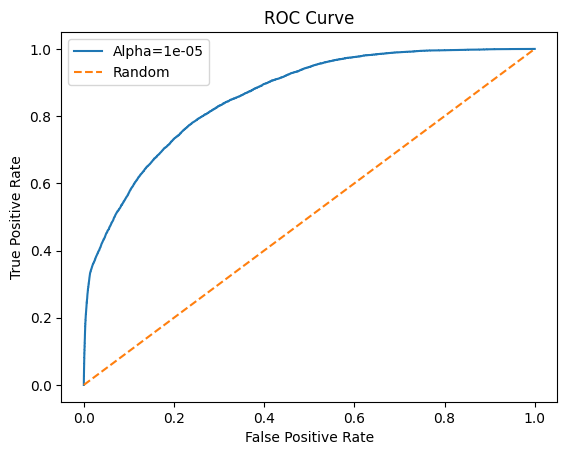

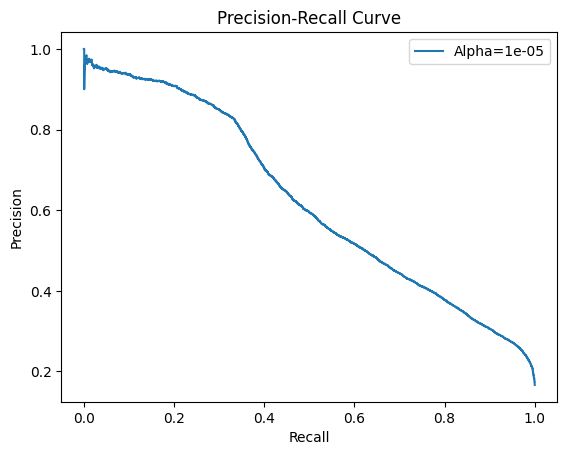

In [ ]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
maxroc = 0
maxaupr = 0
O_alpha = 1e-5
O_pred = None

for alpha in alphas:
    pred = kfold_cv(5, alpha, folds, interactions, c_similarity, d_similarity)
    performance, all_y_true, all_y_score = evaluate_and_collect(pred, folds, interactions)


    if performance["mean_auc_roc"] > maxroc and performance["mean_auc_pr"] > maxaupr:
        maxroc = performance["mean_auc_roc"]
        maxaupr = performance["mean_auc_pr"]
        O_alpha = alpha
        O_pred = pred
        best_y_true = all_y_true  # store for final plotting
        best_y_score = all_y_score

print(f"Best alpha = {O_alpha}, with AUC-ROC={maxroc:.4f}, AUC-PR={maxaupr:.4f}")

# --- Plot ROC and PR curves for the best alpha ---
fpr, tpr, _ = roc_curve(best_y_true, best_y_score)
precision, recall, _ = precision_recall_curve(best_y_true, best_y_score)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'Alpha={O_alpha}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Precision-Recall curve
plt.plot(recall, precision, label=f'Alpha={O_alpha}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
#Evaluation method used in GKLOMLI

def compute_ranking_positions(RS, test_fold_coords, all_known_coords, very_low=-1e20):
    RS_copy = RS.copy()

    test_set = set(test_fold_coords)
    for (i, j) in all_known_coords:
        if (i, j) not in test_set:
            RS_copy[i, j] = very_low

    positions = []
    for (i, j) in test_fold_coords:
        score = RS[i, j]
        ll1 = np.sum(RS_copy >= score)
        ll2 = np.sum(RS_copy > score)
        pos = ll2 + 1 + (ll1 - ll2 - 1) / 2
        positions.append(pos)
    return positions

all_known_coords = list(zip(*np.where(interactions == 1)))

np.random.shuffle(all_known_coords)
test_fold_coords = all_known_coords[:2000]

positions = compute_ranking_positions(O_pred[1], test_fold_coords, all_known_coords)
print("Ranking positions for test interactions:", positions)

import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def ranking_to_score(rank, max_rank):
    return (max_rank - rank) / max_rank

def compute_metrics_from_ranks(pos_ranks, neg_ranks):
    max_rank = max(np.max(pos_ranks), np.max(neg_ranks))

    pos_scores = np.array([ranking_to_score(r, max_rank) for r in pos_ranks])
    neg_scores = np.array([ranking_to_score(r, max_rank) for r in neg_ranks])

    y_true = np.concatenate([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
    y_scores = np.concatenate([pos_scores, neg_scores])

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    return roc_auc, pr_auc, fpr, tpr, precision, recall

if __name__ == '__main__':
    all_negative_coords = list(zip(*np.where(interactions == 0)))
    neg_sample = np.random.choice(len(all_negative_coords), size=5*len(test_fold_coords), replace=False)
    neg_coords = [all_negative_coords[i] for i in neg_sample]

    neg_ranks = compute_ranking_positions(O_pred[1], neg_coords, all_known_coords)

    roc_auc, pr_auc, fpr, tpr, precision, recall = compute_metrics_from_ranks(positions, neg_ranks)

    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)


Ranking positions for test interactions: [659846.0, 679172.5, 658810.0, 660125.0, 725072.0, 750663.0, 692051.0, 115200.0, 613502.0, 87972.0, 670556.5, 712389.0, 669152.0, 712006.0, 670450.5, 668125.0, 661196.0, 730026.0, 665888.0, 105469.0, 737943.0, 705093.5, 50475.0, 34780.5, 768025.0, 674062.0, 258699.0, 188827.0, 712830.0, 447.0, 710651.5, 783957.0, 614058.0, 807403.0, 102.0, 744779.0, 682668.0, 672742.0, 274412.0, 684760.0, 757664.5, 732738.0, 694425.0, 687451.0, 712711.0, 750487.5, 674069.5, 727690.5, 90506.0, 665433.0, 715502.0, 811813.0, 715165.5, 660133.0, 727128.0, 690368.5, 68.0, 731457.0, 681310.5, 662123.5, 739157.0, 722874.0, 763847.0, 609397.0, 57147.5, 610557.0, 622890.0, 692445.0, 466134.0, 680946.0, 697590.0, 686252.0, 651022.5, 676042.0, 670930.0, 697451.0, 663187.0, 726165.0, 712513.0, 6669.0, 1309.0, 620705.0, 734019.0, 710491.0, 97303.0, 720395.5, 659649.0, 713419.0, 709449.0, 672832.0, 355740.0, 764322.0, 662750.0, 708878.0, 682569.0, 715383.0, 737081.5, 705200.0

In [ ]:
print("c_similarity:", np.min(c_similarity), np.max(c_similarity), np.mean(c_similarity))
print("d_similarity:", np.min(d_similarity), np.max(d_similarity), np.mean(d_similarity))
print("RS stats:", np.min(pred[0]), np.max(pred[0]), np.mean(pred[0]), np.std(pred[0]))

c_similarity: 0.10089440171526895 1.0 0.6076383873790898
d_similarity: 0.00925499690629726 1.0 0.6149293839354771
RS stats: -0.007880743854415253 1.0073168570979227 0.4764264137447001 0.28153705859444006
